# 第5章 决策树 （decision tree）
本章实现ID3算法，并复现书中例5.1，例5.3。最后调用sklearn的决策树库函数

决策树最简单的理解是其可以转换为一个if-then结构

决策树旨在学习一个与训练数据拟合很好，并且复杂度小的决策树。由于从可能的决策树中直接选取最优的决策树是一个NP问题，因此采用启发式方法学习次优的决策树。

决策树学习算法包含三个部分：特征选择，树的生成，树的剪枝。常用算法有ID3、C4.5和CART。

## 公式
entropy：$H(x) = -\sum_{i=1}^{n}p_i\log{p_i}$

conditional entropy: $H(X|Y)=\sum{P(X|Y)}\log{P(X|Y)}$

information gain : $g(D, A)=H(D)-H(D|A)$

information gain ratio: $g_R(D, A) = \frac{g(D,A)}{H(A)}$

gini index:$Gini(D)=\sum_{k=1}^{K}p_k\log{p_k}=1-\sum_{k=1}^{K}p_k^2$

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter
import math
from math import log # log() function

import pprint # can print any python structure data

## 例5.1

In [2]:
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    
    return  datasets, labels

In [3]:
datasets, labels = create_data()
train_data = pd.DataFrame(datasets, columns=labels)

In [4]:
train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


In [5]:
# entropy
def calculate_entropy(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    entropy = -sum([(p / data_length) * log(p / data_length, 2) for p in label_count.values()])
    
    return entropy

# conditional entropy
def conditional_entropy(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    conditional_entropy = sum([(len(p) / data_length) * calculate_entropy(p) for p in feature_sets.values()])
    
    return conditional_entropy

# information gain
def info_gain(calculate_entropy, conditional_entropy):
    return calculate_entropy - conditional_entropy

def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    calculate_ent = calculate_entropy(datasets)
    feature_ = []
    for c in range(count):
        c_info_gain = info_gain(calculate_ent, conditional_entropy(datasets, axis=c))
        feature_.append((c, c_info_gain))
        print('feature({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
    #select the best feature
    best_feature = max(feature_, key=lambda x: x[-1])
    return 'feature - ({}) has the maximum information ganin, choose it as the root!'.format(labels[best_feature[0]])

In [6]:
info_gain_train(np.array(datasets))

feature(年龄) - info_gain - 0.083
feature(有工作) - info_gain - 0.324
feature(有自己的房子) - info_gain - 0.420
feature(信贷情况) - info_gain - 0.363


'feature - (有自己的房子) has the maximum information ganin, choose it as the root!'

## 例5.3
利用ID3算法生成决策树

In [7]:
# defining node class binary tree
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {'label:': self.label, 'feature': self.feature, 'tree': self.tree}
    
    def __repr__(self):
        return '{}'.format(self.result)
    
    def add_node(self, val, node):
        self.tree[val] = node
        
    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)
    
class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}
        
    # entropy
    @staticmethod
    def calculate_entropy(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        entropy = -sum([(p / data_length) * log(p / data_length, 2) for p in label_count.values()])
        return entropy
    
    # conditional entropy
    def conditional_entropy(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        conditional_entropy = sum([(len(p) / data_length) * self.calculate_entropy(p) for p in feature_sets.values()])
        return conditional_entropy
    
    # information gain
    @staticmethod
    def info_gain(calculate_entropy, conditional_entropy):
        return calculate_entropy - conditional_entropy
    
    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calculate_entropy(datasets)
        feature_ = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.conditional_entropy(datasets, axis=c))
            feature_.append((c, c_info_gain))
        # select the best feature
        best_feature = max(feature_, key=lambda x: x[-1])
        return best_feature
    
    # train the data
    def train(self, train_data):
        '''
        input:datasets:D(DataFrame form), feature sets:A, threshold:eta
        output: decision tree:T
        '''
        _, y_train, features = train_data.iloc[:, -1], train_data.iloc[:, -1], train_data.columns[:-1]
        
        # 1. If the instances in D belong to the same class C_k, T is a single node tree. Using class C_k as the class tag of the node and return T.
        if len(y_train.value_counts()) == 1:
            return Node(root=True, label=y_train.iloc[0])
        
        #2. If the A is empty, T is a single node tree. Using class C_k, which is the maximum class of the instances in D, as the class tag
        # of the node label, return T.
        if len(features) == 0:
            return Node(root=True, label=y_train.value_count().sort_values(ascending=False).index[0]) #ascending: True means ascending
        
        #3. calculate the maximum information gain. As shown in example 5.1, Ag is the feature which has the maximum information gain.
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]
        
        #4. If Ag's information gain is less than threshold eta, T is a single node tree. 
        #Using the maximum class C_k of instances in D as the class tag, return T
        if max_info_gain < self.epsilon:
            return Node(root=Truem, label=y_train.value_counts().sort_values(ascending=False).index[0])
        
        #5. building Ag sub-datasets
        node_tree = Node(root=False, feature_name=max_feature_name, feature=max_feature)
        
        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] == f].drop([max_feature_name], axis=1)
            
            # 6. Recursive  generate tree
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)
            
            return node_tree
        
    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree
        
    def predict(self, X_test):
        return self._tree.predict(X_test)

In [8]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

In [9]:
tree

{'label:': None, 'feature': 2, 'tree': {'否': {'label:': None, 'feature': 1, 'tree': {'否': {'label:': '否', 'feature': None, 'tree': {}}}}}}

In [10]:
dt.predict(['老年', '否', '否', '一般'])

'否'

## sklearn.tree.DecisionTreeClassifier
#### criterion:string, optional(default='gini')
The function to measure the equality of a split. Supported criteria are 'gini' for the Gini impurity and 'entropy' for the information gain.

In [11]:
# create data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    return data[:, :2], data[:, -1]

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
import graphviz

In [13]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [14]:
clf.score(X_test, y_test)

1.0

In [15]:
tree_pic = export_graphviz(clf, out_file='DecisionTree_ID3_iris.pdf')
with open('DecisionTree_ID3_iris.pdf') as f:
    dot_graph = f.read()

graphviz是一个开源的图形可视化软件，与其他图形软件所不同，它的理念是“所想即所得”，通过dot语言来描述并绘制图形。

首先是安装，在ubuntu下，可以直接使用命令来安装:
- ① sudo apt-get install graphviz
- ② pip install graphviz

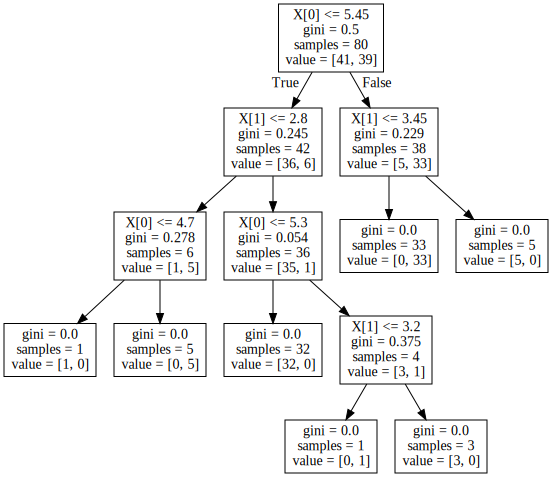

In [16]:
graphviz.Source(dot_graph)